In [153]:
import numpy as np
import pandas as pd
import tensorflow as tf
import h5py
from utils import *
from sklearn.model_selection import train_test_split
import os


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1- Data
### 1.2- Load & Split Data
**Unfortunately** the give dataset in `.h5` file format did not opened, I printed the error mwssage.

**kaggle**: Then I downloaded the similar dataset from kaggle and i provided a helper function given the API command e.g. `!kaggle datasets download -d ardamavi/sign-language-digits-dataset` you can easily download and extract zip file. but remember to set up the kaggle's API token in your system according to the instructions. or you can manually download and extract it.

**Sign Language digits dataset**: 
+ It consists of ranges of numbers from **0** to **10**, which are **one-hot encoded**.
+ all images are gray scaled, so it needs to be reshaped for its color channel which is 1 variable for all pictures.
+ the values are already normalized

In [3]:
try:
    train = h5py.File('datasets/dataset/train_signs.h5')
    test = h5py.File('datasets/dataset/test_signs.h5')
except Exception as e:
    print('[ERROR]', e)

[ERROR] Unable to open file (file signature not found)


In [11]:
kaggle_command = '!kaggle datasets download -d ardamavi/sign-language-digits-dataset'

load_dataset_kaggle(kaggle_command)

[NOTE] Start loading sign-language-digits-dataset
[NOTE] Did not find dataset/sign-language-digits-dataset directory, creating one...
[NOTE] Start downloading dataset from kaggle.
[NOTE] Unzipping the dataset


In [4]:
X = np.load('dataset/sign-language-digits-dataset/X.npy')
Y = np.load('dataset/sign-language-digits-dataset/Y.npy')

print('min:{}'.format(np.min(X)))
print('max:{}'.format(np.max(X)))

X = np.concatenate((X[204:409,:],
                                   X[822:1028,:],
                                   X[1649:1855,:],
                                   X[1443:1649,:],
                                   X[1236:1443,:],
                                   X[1855:2062,:],
                                   X[615:822,:],
                                   X[409:615,:],
                                   X[1028:1236,:],
                                   X[0:204,:]),axis = 0)
X.shape, Y.shape

min:0.003921568859368563
max:1.0


((2062, 64, 64), (2062, 10))

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
print('[SHAPES] X_train:{} | Y_train:{} | X_test:{} | Y_test:{}'
      .format(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape))

[SHAPES] X_train:(1855, 64, 64) | Y_train:(1855, 10) | X_test:(207, 64, 64) | Y_test:(207, 10)


In [9]:
X_train = tf.data.Dataset.from_tensor_slices(X_train)
Y_train = tf.data.Dataset.from_tensor_slices(Y_train)
X_test = tf.data.Dataset.from_tensor_slices(X_test)
Y_test = tf.data.Dataset.from_tensor_slices(Y_test)

type(X_train)

tensorflow.python.data.ops.from_tensor_slices_op.TensorSliceDataset

In [65]:
print(next(iter(X_train)))

tf.Tensor(
[[[0.8039216 ]
  [0.80784315]
  [0.80784315]
  ...
  [0.8117647 ]
  [0.8039216 ]
  [0.7882353 ]]

 [[0.8       ]
  [0.8039216 ]
  [0.8039216 ]
  ...
  [0.8117647 ]
  [0.80784315]
  [0.7921569 ]]

 [[0.8       ]
  [0.8039216 ]
  [0.8117647 ]
  ...
  [0.8117647 ]
  [0.8117647 ]
  [0.8039216 ]]

 ...

 [[0.6666667 ]
  [0.6901961 ]
  [0.7254902 ]
  ...
  [0.7254902 ]
  [0.72156864]
  [0.7176471 ]]

 [[0.6666667 ]
  [0.6862745 ]
  [0.72156864]
  ...
  [0.72156864]
  [0.7137255 ]
  [0.70980394]]

 [[0.65882355]
  [0.6862745 ]
  [0.72156864]
  ...
  [0.7176471 ]
  [0.70980394]
  [0.70980394]]], shape=(64, 64, 1), dtype=float32)


In [10]:
shape_train = [x.get_shape().as_list() for x in Y_train._tensors]
print('shape of training set', shape_train)

unique_labels = [x for x in range(shape_train[0][1])]
unique_labels

shape of training set [[1855, 10]]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

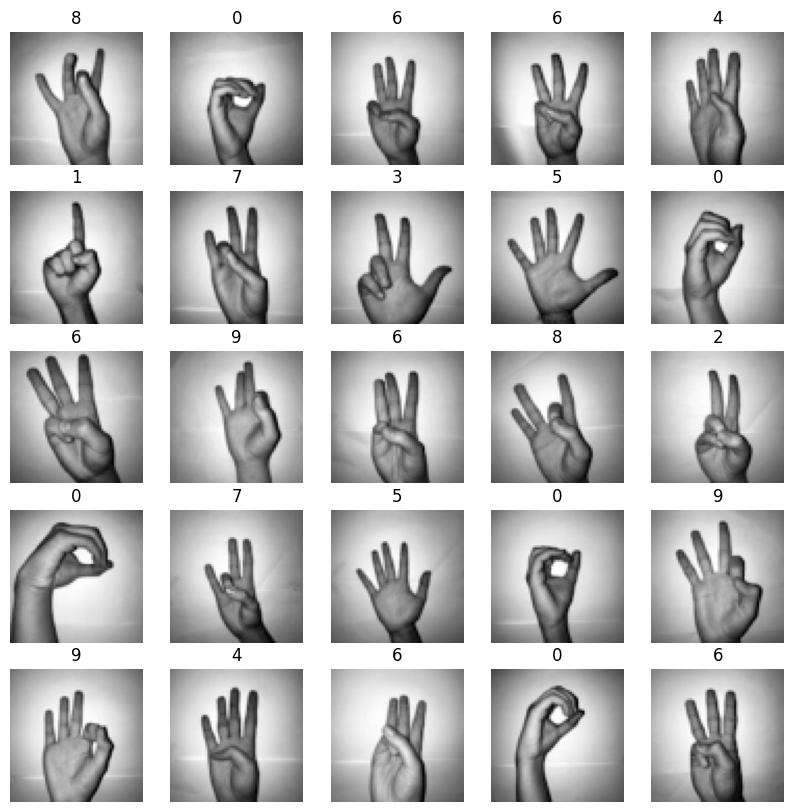

In [138]:
images_iter = iter(X_train)
labels_iter = iter(Y_train)

plt.figure(figsize=(10,10))
for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(next(images_iter).numpy().astype('float32'), cmap='gray')
    plt.title(np.argmax(next(labels_iter).numpy().astype('float32'), axis=0))
    plt.axis('off')

In [83]:
def reshape_image(image):
    return tf.reshape(image, [-1,])

X_train = X_train.map(reshape_image)
X_test = X_test.map(reshape_image)

X_train.element_spec, X_test.element_spec

(TensorSpec(shape=(4096,), dtype=tf.float32, name=None),
 TensorSpec(shape=(4096,), dtype=tf.float32, name=None))

In [146]:
print(next(iter(X_train)))

tf.Tensor([0.4745098  0.49019608 0.49803922 ... 0.47843137 0.47058824 0.45882353], shape=(4096,), dtype=float32)


## 2- Basic Oprimization with GradientTape
### 2.1- Linear function

In [17]:
def linear_function():
    np.random.seed(1)  # to pass the below test
    X = tf.constant(np.random.randn(3,1), name='X')
    W = tf.constant(np.random.randn(4,3), name='W')
    b = tf.constant(np.random.randn(4,1), name='b')
    return tf.add(tf.matmul(W, X), b)

In [154]:
# testing 
linear_function_test(linear_function)

tf.Tensor(
[[-2.15657382]
 [ 2.95891446]
 [-1.08926781]
 [-0.84538042]], shape=(4, 1), dtype=float64)
All test passed


### 2.2- Computing the Sigmoid
+ `tf.sigmoid`: rquires float16, float32, float64, complex64, or complex128.
+ `tf.softmax`
+ `tf.cast`: to change/cast the tensor type to `tf.float32`.

In [23]:
def sigmoid(z):
    z = tf.cast(z, tf.float32)
    return tf.keras.activations.sigmoid(z)

In [151]:
# testing
sigmoid_test(sigmoid)

type: <class 'tensorflow.python.framework.ops.EagerTensor'>
dtype: <dtype: 'float32'>
sigmoid(-1) = tf.Tensor(0.5, shape=(), dtype=float32)
sigmoid(0) = tf.Tensor(0.5, shape=(), dtype=float32)
sigmoid(12) = tf.Tensor(0.99999386, shape=(), dtype=float32)
All test passed


### 2.3- One Hot Encoding
my dataset has already been encoded using One-Hot encoding method, so I just write the helper function for the sake of completeness

In [42]:
def one_hot_matrix(label, depth=10):
    return tf.reshape(tf.one_hot(label, depth, axis=0), (depth,))

In [43]:
# testing
one_hot_matrix_test(one_hot_matrix)

Test 1: tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
Test 2: tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)
All test passed


### 2.4- Initialize Parameters
+ `tf.keras.initializers.GlorotNormal`: Draws samples from a truncated normal distribution centered on 0 with `stddev = sqrt(2 / (fan_in + fan_out))` where fan_in is the number of input units in the weight tensor and fan_out is the number of output units in the weight tensor.

In [120]:
def initialize_parameters(dims):
    params = {}
    initializer = tf.keras.initializers.GlorotNormal(seed=1)
    for i in range(1, 4):
        params[f'W{i}'] = tf.Variable(initializer(shape=dims[i-1], dtype=tf.float32))
        params[f'b{i}'] = tf.Variable(initializer(shape=(dims[i-1][0], 1), dtype=tf.float32))
    return params


In [121]:
# testing
dims = [(25, 12288), (12, 25), (10, 12)]
    
initialize_parameters_test(initialize_parameters, dims)

W1 shape: (25, 12288)
b1 shape: (25, 1)
W2 shape: (12, 25)
b2 shape: (12, 1)
W3 shape: (10, 12)
b3 shape: (10, 1)
All test passed


## 3- Building First Neural Network
There are only two part to implement tensorflow model:
+ Forward propagation
+ Retrieve gradients and train the model

### 3.1- Implement Forward Propagation

In [122]:
def forward_propagation(X, params):
    A = X
    for i in range(1, len(params)//2 + 1):
        Z = tf.math.add(tf.linalg.matmul(params[f'W{i}'], A), params[f'b{i}'])
        A = tf.keras.activations.relu(Z)
    return Z

In [123]:
# testing
dims = [(25, 4096), (12, 25), (10, 12)]
params = initialize_parameters(dims)

forward_propagation_test(forward_propagation, X_train, params)

tf.Tensor(
[[ 0.84769773  0.84271014]
 [-0.19436288 -0.08474529]
 [ 0.8452729   0.9660455 ]
 [-0.69748175 -0.6749563 ]
 [-0.37209427 -0.47074446]
 [ 0.87136906  0.8759996 ]
 [-1.0625029  -1.125573  ]
 [ 2.1713765   2.2373447 ]
 [ 0.11654596  0.05260302]
 [-1.0685112  -1.0504675 ]], shape=(10, 2), dtype=float32)
All test passed


### 3.2- Compute Cost

In [124]:
def compute_cost(logits, labels):
    return tf.reduce_mean(tf.keras.metrics.categorical_crossentropy(tf.transpose(labels),
                                                                    tf.transpose(logits),
                                                                    from_logits=True))

In [125]:
# testing
compute_cost_test(compute_cost, Y_train )

tf.Tensor(6.1703625, shape=(), dtype=float32)
5.7652187
All test passed


### 3.3- Train Model
**Optimizer**: `tf.keras.optimizers.Adam`

**record Differentation**: `tf.GradientTape`

**Sources**:
+ Introduction to Gradients and Automatic Differentiation: 
https://www.tensorflow.org/guide/autodiff 

+ GradientTape documentation:
https://www.tensorflow.org/api_docs/python/tf/GradientTape

`.prefetch()`: Most dataset input pipelines should end with a call to prefetch. This allows later elements to be prepared while the current element is being processed. This often improves **latency** and **throughput**, at the cost of using **additional memory to store prefetched** elements

In [135]:
def model(X_train, Y_train, X_test, Y_test, dims, learning_rate=0.0001, 
          num_epochs=1500, minibatch_size=32, print_cost=True, history=True):

    costs = []
    train_acc = []
    test_acc = []

    params = initialize_parameters(dims)
    optimizer = tf.optimizers.Adam(learning_rate)

    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    test_accuracy = tf.keras.metrics.CategoricalAccuracy()
    train_dataset = tf.data.Dataset.zip((X_train, Y_train))
    test_dataset = tf.data.Dataset.zip((X_test, Y_test))

    train_minibatches = train_dataset.batch(minibatch_size).prefetch(8)
    test_minibatches = test_dataset.batch(minibatch_size).prefetch(8)

    m = train_dataset.cardinality().numpy()
    print('size of examples is:', m)

    for epoch in range(num_epochs):
        epoch_cost = 0

        # training
        train_accuracy.reset_states()

        for(minibatch_X, minibatch_Y) in train_minibatches:
            with tf.GradientTape() as tape:

                logits = forward_propagation(tf.transpose(minibatch_X), params)

                minibatch_cost = compute_cost(logits, tf.transpose(minibatch_Y))
            
            train_accuracy.update_state(tf.transpose(logits), minibatch_Y)

            trainable_variables = [params[w] for w in params.keys()]
            grads = tape.gradient(minibatch_cost, trainable_variables)
            optimizer.apply_gradients(zip(grads, trainable_variables))

            epoch_cost += minibatch_cost
        
        epoch_cost /= m

        if epoch % 10 == 0 :
            for (minibatch_X, minibatch_Y) in test_minibatches:
                logits = forward_propagation(tf.transpose(minibatch_X), params)
                test_accuracy.update_state(tf.transpose(logits), minibatch_Y)

            if print_cost:
                print('after epoch:{} | cost{} | train accuracy:{} | test accuracy:{}'
                    .format(epoch, epoch_cost, train_accuracy.result(), test_accuracy.result()))
                
            if history:
                costs.append(epoch_cost)
                train_acc.append(train_accuracy.result())
                test_acc.append(test_accuracy.result())
                test_accuracy.reset_states()
        
    return params, costs, train_acc, test_acc

In [136]:
dims = [(25, 4096), (12, 25), (10, 12)]
params, costs, train_acc, test_acc = model(X_train, Y_train, X_test, Y_test, dims, num_epochs=100)

size of examples is: 1855
after epoch:0 | cost0.0730065405368805 | train accuracy:0.10673854500055313 | test accuracy:0.10144927352666855
after epoch:10 | cost0.06123362481594086 | train accuracy:0.32560646533966064 | test accuracy:0.3526569902896881
after epoch:20 | cost0.053593941032886505 | train accuracy:0.43180593848228455 | test accuracy:0.4444444477558136
after epoch:30 | cost0.04684290662407875 | train accuracy:0.5261455774307251 | test accuracy:0.5265700221061707
after epoch:40 | cost0.04131442680954933 | train accuracy:0.5935310125350952 | test accuracy:0.5893719792366028
after epoch:50 | cost0.037237498909235 | train accuracy:0.6377358436584473 | test accuracy:0.6328502297401428
after epoch:60 | cost0.03433744236826897 | train accuracy:0.6630727648735046 | test accuracy:0.6570048332214355
after epoch:70 | cost0.032131318002939224 | train accuracy:0.6814016103744507 | test accuracy:0.6666666865348816
after epoch:80 | cost0.03032303974032402 | train accuracy:0.701886773109436 

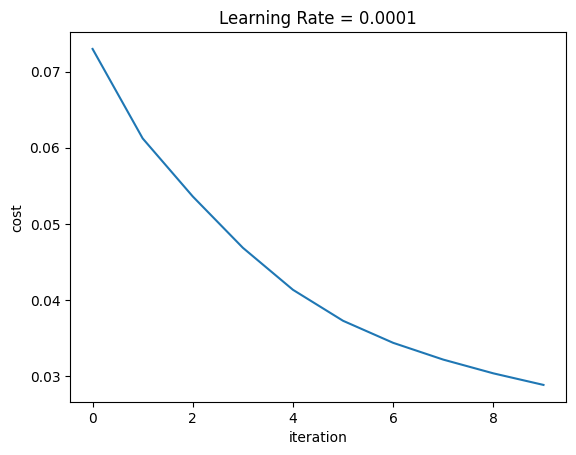

In [137]:
# plot the cost
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iteration')
plt.title('Learning Rate = 0.0001')
plt.show()

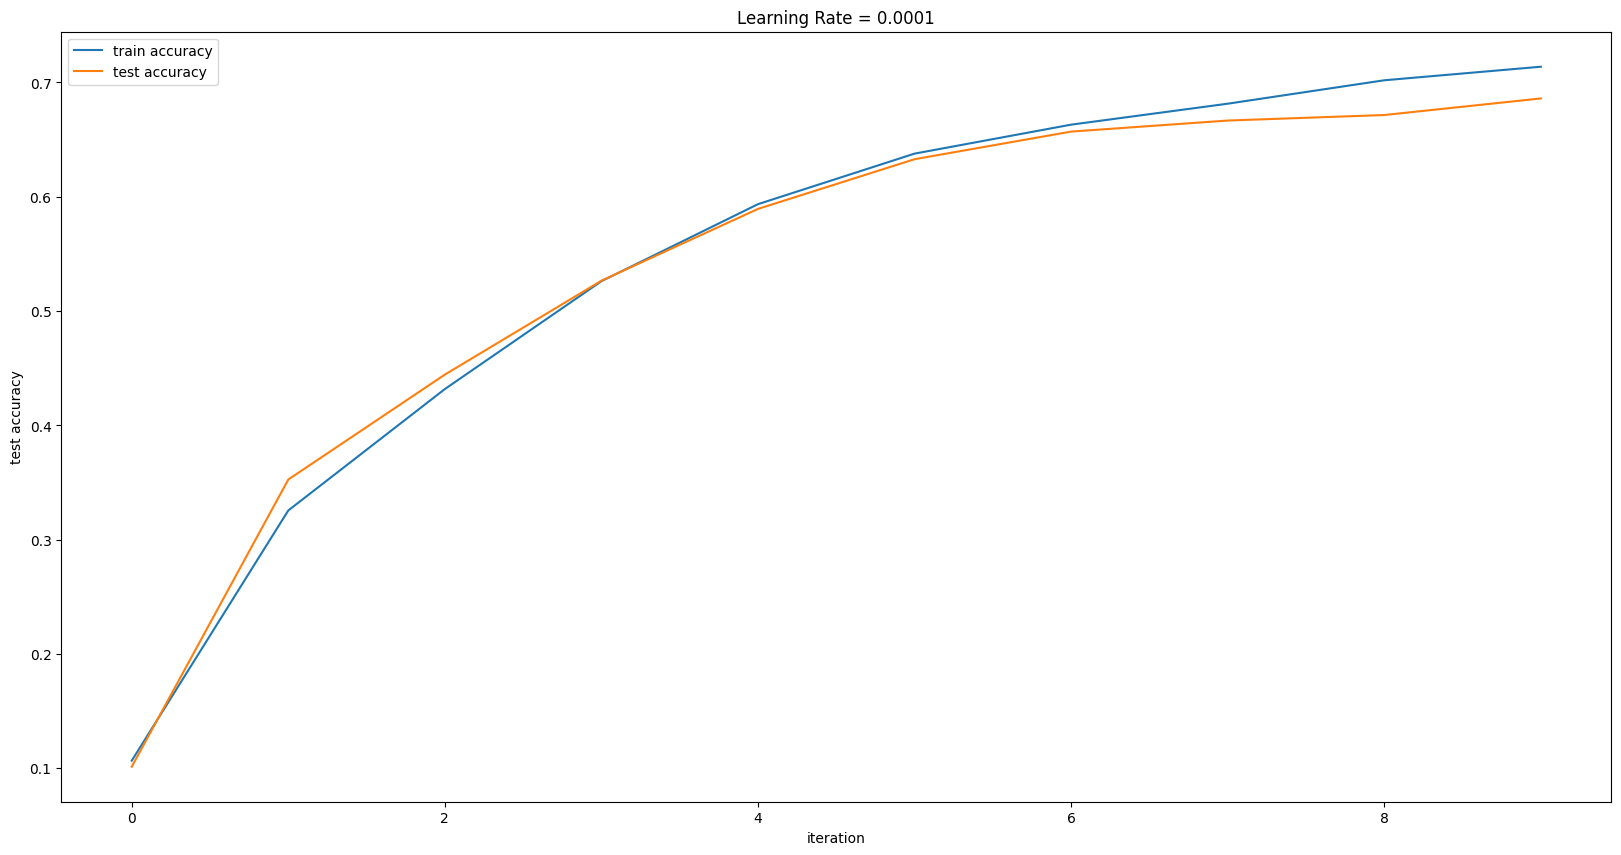

In [147]:
# plot the train accuracy
plt.figure(figsize=(20,10))

plt.plot(np.squeeze(train_acc), label='train accuracy')
plt.ylabel('train accuracy')
plt.xlabel('iteration')
plt.title('Learning Rate = 0.0001')

plt.plot(np.squeeze(test_acc), label='test accuracy')
plt.ylabel('test accuracy')
plt.xlabel('iteration')
plt.title('Learning Rate = 0.0001')

plt.legend()
plt.show()